## Importing libraries

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

## Loading the data

In [45]:
gstock_data=pd.read_csv('NIFTY BANK_Data.csv'); gstock_data

,Date,Open,High,Low,Close
0,06-May-22,34569.10,34797.95,34353.20,34591.20
1,05-May-22,35705.35,35934.85,35133.80,35232.85
2,04-May-22,36266.15,36309.30,35127.85,35264.55
3,02-May-22,35627.60,36235.25,35618.20,36163.75
4,29-Apr-22,36474.05,36718.80,35978.95,36088.15
...,...,...,...,...,...
3299,07-Jan-09,5416.35,5440.55,4954.00,4984.50
3300,06-Jan-09,5333.50,5448.80,5276.40,5395.30
3301,05-Jan-09,5273.45,5371.10,5273.45,5359.40
3302,02-Jan-09,5154.20,5258.65,5103.60,5195.10


In [46]:
gstock_data['Date'] = pd.to_datetime(gstock_data['Date'], format='%d-%b-%y')
gstock_data = gstock_data.sort_values(by='Date',ascending=True)
gstock_data['Date'] = gstock_data['Date'].dt.strftime('%d-%m-%Y') 
gstock_data.set_index('Date',drop=True,inplace=True) 
gstock_data

,Open,High,Low,Close
Date,,,,
01-01-2009,5019.20,5135.15,5019.20,5116.50
02-01-2009,5154.20,5258.65,5103.60,5195.10
05-01-2009,5273.45,5371.10,5273.45,5359.40
06-01-2009,5333.50,5448.80,5276.40,5395.30
07-01-2009,5416.35,5440.55,4954.00,4984.50
...,...,...,...,...
29-04-2022,36474.05,36718.80,35978.95,36088.15
02-05-2022,35627.60,36235.25,35618.20,36163.75
04-05-2022,36266.15,36309.30,35127.85,35264.55


In [67]:
data = gstock_data.drop(['Open', 'High', 'Low'], axis = 1); data

,Close
Date,
01-01-2009,5116.50
02-01-2009,5195.10
05-01-2009,5359.40
06-01-2009,5395.30
07-01-2009,4984.50
...,...
29-04-2022,36088.15
02-05-2022,36163.75
04-05-2022,35264.55


In [68]:
date = list(gstock_data.index)

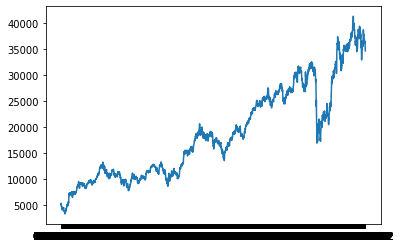

In [6]:
plt.plot(data)      ##visualising the data

## Data loading and train-test split

In [69]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.1*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    date_train = date[:train_set_size]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    date_test = date[train_set_size:-11]
    
    return [x_train, y_train, date_train, x_test, y_test, date_test]
sc = MinMaxScaler()
data = sc.fit_transform(data)
look_back = 11 # choose sequence length
x_train, y_train, date_train, x_test, y_test, date_test = load_data(data, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('date_train length = ', len(date_train))
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape) 
print('date_test length = ', len(date_test))

x_train.shape =  (2964, 10, 1)
y_train.shape =  (2964, 1)
date_train length =  2964
x_test.shape =  (329, 10, 1)
y_test.shape =  (329, 1)
date_test length =  329


In [70]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

## Building the model

In [71]:
# Build model
#####################
input_dim = 1
hidden_dim = 10
num_layers = 4 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 10, num_layers=4, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
18
torch.Size([40, 1])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])
torch.Size([40, 10])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])
torch.Size([40, 10])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])
torch.Size([40, 10])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])
torch.Size([1, 10])
torch.Size([1])


In [72]:
sum(i.numel() for i in model.parameters()) ##no. of parameters

3171

## Training the model

In [73]:
# Train model
#####################
num_epochs = 850
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  


for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.056984540075063705
Epoch  20 MSE:  0.04331076145172119
Epoch  30 MSE:  0.03857920691370964
Epoch  40 MSE:  0.037456680089235306
Epoch  50 MSE:  0.03733109310269356
Epoch  60 MSE:  0.03712946176528931
Epoch  70 MSE:  0.03559240326285362
Epoch  80 MSE:  0.021033477038145065
Epoch  90 MSE:  0.0026866053231060505
Epoch  100 MSE:  0.0013543831882998347
Epoch  110 MSE:  0.0009343675337731838
Epoch  120 MSE:  0.0008267220691777766
Epoch  130 MSE:  0.0007106073899194598
Epoch  140 MSE:  0.000592582393437624
Epoch  150 MSE:  0.0005208462243899703
Epoch  160 MSE:  0.0004746761405840516
Epoch  170 MSE:  0.00045699765905737877
Epoch  180 MSE:  0.0004440278862603009
Epoch  190 MSE:  0.0004358464211691171
Epoch  200 MSE:  0.0004294410173315555
Epoch  210 MSE:  0.00042392563773319125
Epoch  220 MSE:  0.0004185432044323534
Epoch  230 MSE:  0.0004127622814849019
Epoch  240 MSE:  0.0004064352251589298
Epoch  250 MSE:  0.0004004441434517503
Epoch  260 MSE:  0.00040560620254836977
Epoch 

## Testing

In [74]:
# make predictions
y_test_pred = model(x_test)
y_train_pred = model(x_train)



# invert predictions
y_train_pred = sc.inverse_transform(y_train_pred.data.numpy())
y_train = sc.inverse_transform(y_train.data.numpy())
y_test_pred = sc.inverse_transform(y_test_pred.data.numpy())
y_test = sc.inverse_transform(y_test.data.numpy())

# calculate root mean squared error
trainScore = sqrt(mse(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mse(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 507.02 RMSE
Test Score: 1436.05 RMSE


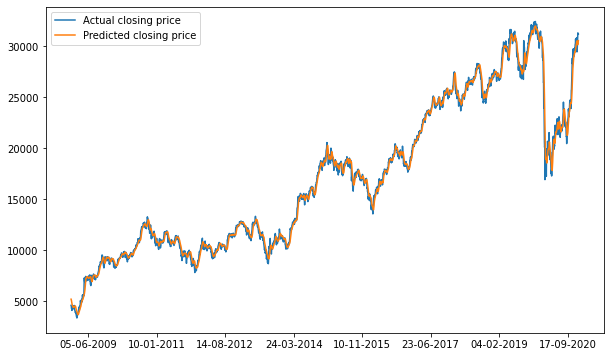

In [81]:
plt.figure(figsize=(10,6))
plt.plot(y_train, label = 'Actual closing price')
plt.plot(y_train_pred, label = 'Predicted closing price')
index = np.arange(100,2928,400)

plt.xticks(index, labels = date_train[100:2928:400])
plt.legend()
plt.show()

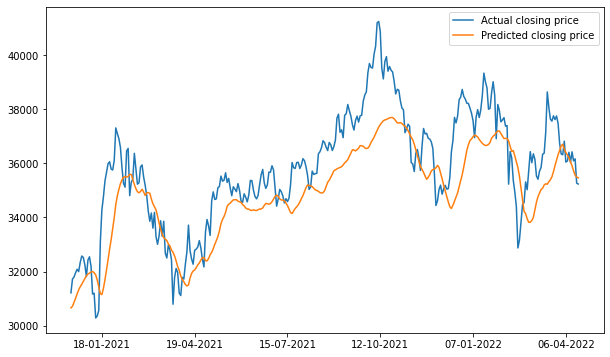

In [80]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label = 'Actual closing price')
plt.plot(y_test_pred, label = 'Predicted closing price')
index = np.arange(20,330,60)
plt.xticks(index, labels = date_test[20:330:60])
plt.legend()
plt.show()